## Introduction

In this notebook I am trying to implement image 2 image pipeline where given a text and initial image,  diffusion models try to generate an image.

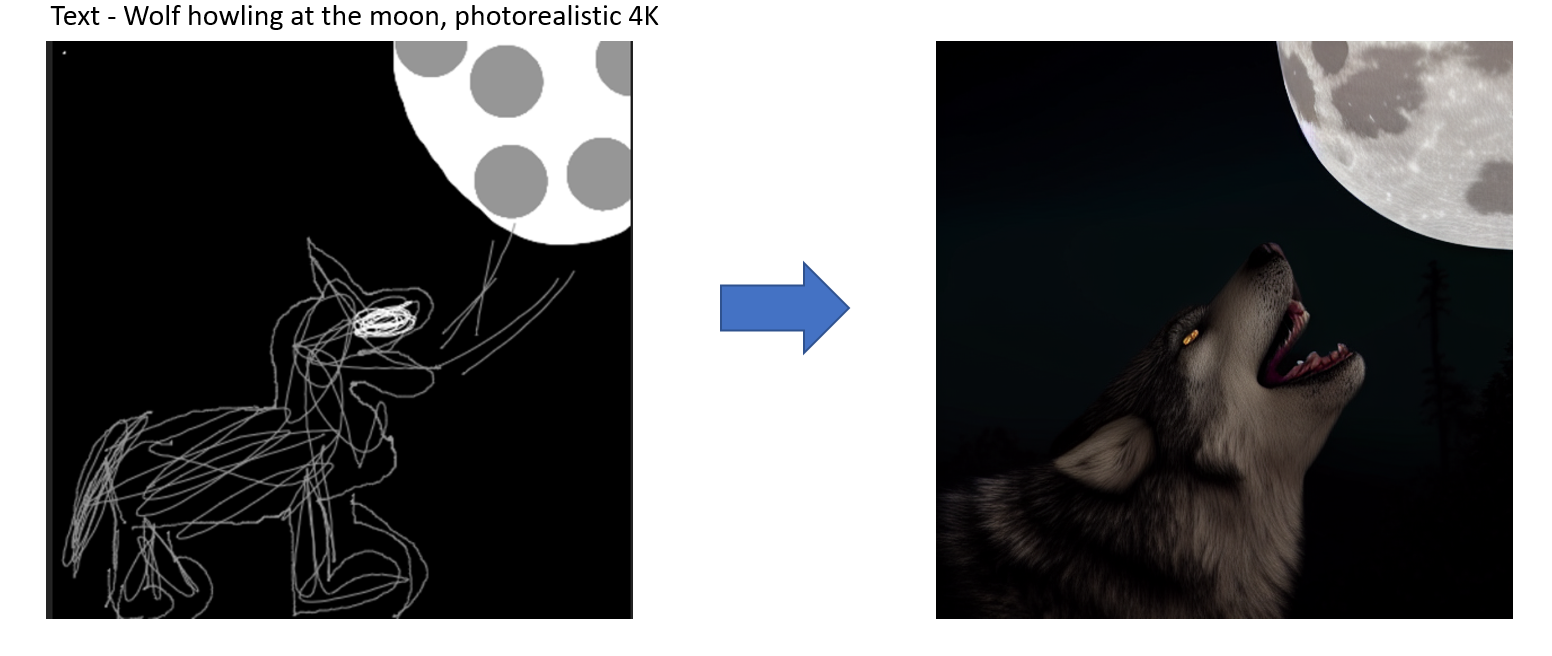

## Importing libraries

In [1]:
import torch, logging
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers import StableDiffusionImg2ImgPipeline
import PIL
from PIL import Image
from pathlib import Path
from fastdownload import FastDownload
from torchvision import transforms as tfms
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
logging.disable(logging.WARNING) ## ignore warnings
%matplotlib inline

## Pre loading models

Stable diffusion model depends on three things - 
1. `CLIP model` - For converting promts to a embedding which gives the visual clue
2. `VAE (Variational Auto Encoder)` - To reduce the dimensions of the original image for faster computations
3. `UNET` - The model which takes a noisy i/p and embedded promt to predict the noise present in the i/p

### Importing diffusion UNet and VAE

In [2]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### CLIP artifacts

In this case, we are using CLIP model which converts the texual prompt into an embedding. To do this using transformers library ,we need two things - 
- 1) `Tokenizer` - This function takes the raw text, breaks it into words and then convert them into numeric forms
- 2) `text_encoder` - This function takes the tokenizer ip and convert them into embeddings

In [3]:
## Loading clip tokenizer and encoder 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### Scheduler Artifacts

This tells the model on how much noise to add at a given timestep

In [4]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

## Simple text to image inference

In [5]:
def preprocess(image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    """
    A function to take the sample and convert it back into the original image
    """
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [6]:
def mk_samples_i2i(prompts, init_img, neg_prompt=None, g=7.5, strength =0.8, seed=100, steps=50, dim=512):
    if seed: torch.manual_seed(seed)
    
    # Step 1: Encode text
    text = text_enc(prompts) 
    if not neg_prompt:
        uncond =  text_enc([""], text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
        
    emb = torch.cat([uncond, text])
    
    # Step 2: Initiate scheduler step
    scheduler.set_timesteps(steps)
    
    # Step 3: Covert image to latents
    init_latents = preprocess(image) # encoded output from VAE
    #init_latents = torch.cat([init_latents] * 1, dim=0) # optional
    
    # Step 4: Figuring initial time step based on strength
    ## offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(steps * strength) #+ offset
    #init_timestep = min(init_timestep, num_inference_steps)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")

    # Step 5: Adding noise to inital image
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Step 6: figuring out the time step to start with
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Step 7: Running diffusion loop
    for i,ts in enumerate(tqdm(timesteps)):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, ts)
        with torch.no_grad():
            u,t = unet(latent_model_input, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample
    
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [7]:
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
image = Image.open(p).convert('RGB').resize((512,512))

In [8]:
prompt = "Wolf howling at the moon, photorealistic 4K"
images = mk_samples_i2i(prompts = prompt, init_img = image)

  0%|          | 0/40 [00:00<?, ?it/s]

/home/aayushmnit/miniconda3/lib/python3.9/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:146: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated_coeff = integrate.quad(lms_derivative, self.sigmas[t], self.sigmas[t + 1], epsrel=1e-4)[0]


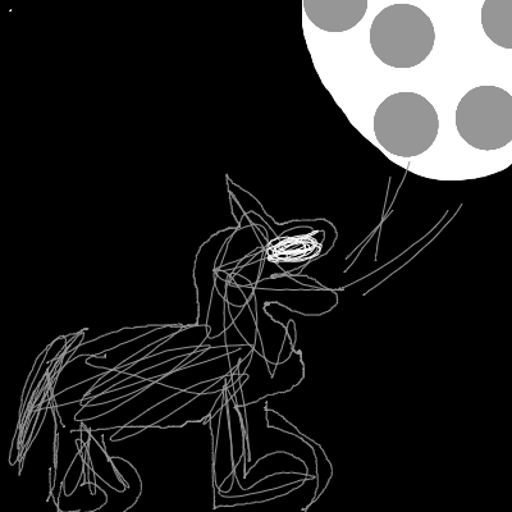

In [10]:
display(image)

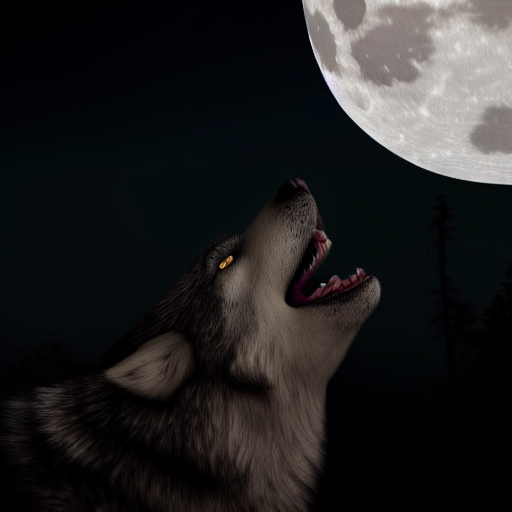

In [9]:
for img in images:display(mk_img(img))